### Midas

Código provindo em partes do tutorial https://pytorch.org/hub/intelisl_midas_v2/

In [1]:
import cv2
import torch
import numpy as np
import time
import os, glob, re, json
import matplotlib.pyplot as plt
from typing import List, Tuple

def load_models(model_type: str):
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform
    return midas, transform, device

# RODE APENAS UMA VEZ. SE RODAR MAIS DE UMA, ESTOURA MEMORIA POR CARREGAR O MODELO DE NOVO
midas_s, transform_s, device = load_models("MiDaS_small")
midas_h, transform_h, device = load_models("DPT_Hybrid")

Using cache found in C:\Users\tsela/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\tsela\anaconda3\envs\VisComp\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in C:\Users\tsela/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\tsela/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\tsela/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\tsela\anaconda3\envs\VisComp\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in C:\Users\tsela/.cache\torch\hub\intel-isl_MiDaS_master


In [3]:
THRESHOLDS = [0.2, 0.5] # Duas divisoes para 3 niveis de profundidade (longe, medio, perto)

def carregar_imagem(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"[aviso] não consegui abrir: {path}")
    return img

def _regex_tail_number(s: str) -> int:
    """
    Extrai um número "útil" do fim do nome para ordenação. 
    Se não encontrar, tenta qualquer número em s; se ainda não, retorna 0.
    """
    base = os.path.basename(s)
    m = re.search(r'(\d+)(?=\D*$)', base)  # último bloco numérico antes do fim
    if m: return int(m.group(1))
    m2 = re.search(r'(\d+)', base)
    return int(m2.group(1)) if m2 else 0

def ordenar_arquivos_imagem(caminho_pasta: str) -> List[str]:
    padroes = ['*.jpg','*.jpeg','*.png','*.bmp','*.tif','*.tiff','*.webp']
    arquivos = []
    for p in padroes:
        arquivos.extend(glob.glob(os.path.join(caminho_pasta, p)))
    arquivos = list(set(arquivos))  # evita duplicados por padrões sobrepostos
    if not arquivos:
        return []
    arquivos.sort(key=lambda f: (_regex_tail_number(f), os.path.basename(f).lower()))
    return arquivos

def get_imgs(caminho_pasta):
    img_list = []

    raiz_resultados = os.path.join(
        "resultados_etapa2", os.path.basename(os.path.normpath(caminho_pasta)))
    os.makedirs(raiz_resultados, exist_ok=True)

    arquivos_de_imagem = ordenar_arquivos_imagem(caminho_pasta)
    if len(arquivos_de_imagem) < 1:
        print("Erro: É necessária pelo menos 1 imagem na pasta.")
        return
    for i, caminho in enumerate(arquivos_de_imagem):
        img = carregar_imagem(caminho)
        if img is not None:
            img_list.append(img)
    return img_list

def get_depth(midas, input_batch, img):
    with torch.no_grad():
        #start_time = time.time()
        prediction = midas(input_batch)
        #end_time = time.time()
        #print(f"Inference time: {end_time - start_time:.4f} seconds")

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

        output = prediction.cpu().numpy()
        output = (output - output.min()) / (output.max() - output.min())
    
    return output


def get_depth_from_images(midas, transform, device, path):
    output_list = []
    img_list = get_imgs(path)
    
    if not img_list:
        return None
    
    for img in img_list:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        input_batch = transform(img).to(device)

        output = get_depth(midas, input_batch, img)
        
        output_list.append(output)

    return output_list

def thresholds_depth(depth_map: np.ndarray):
    t1, t2 = THRESHOLDS  # quanto maior o valor, mais perto da camera
    result = np.zeros_like(depth_map)  # Start with all zeros
    result[(depth_map >= t1) & (depth_map < t2)] = 1  # Middle threshold
    result[depth_map >= t2] = 2  # Closest threshold
    return result

def show_images(*images):
    n = len(images)
    for i in range(n):
        plt.figure()
        plt.title(f"Img {i + 1}")
        plt.imshow(images[i], cmap='viridis')
        plt.colorbar(label="Depth Value")
        plt.axis('off')
    plt.show()

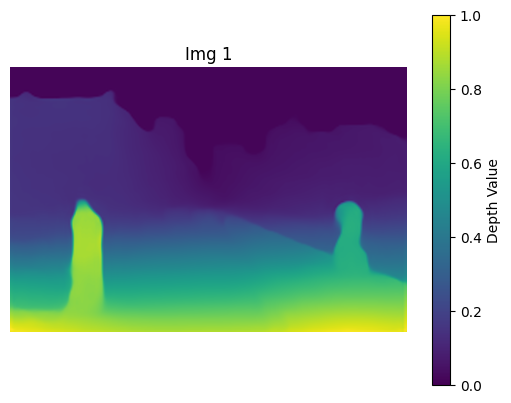

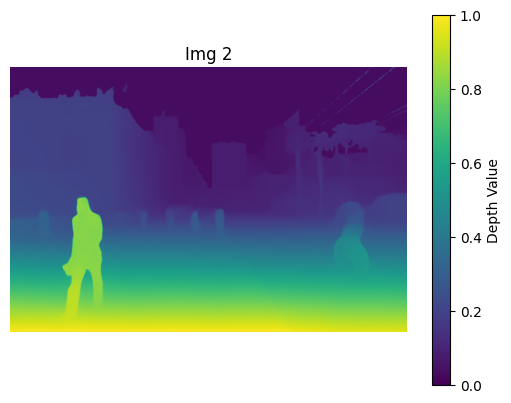

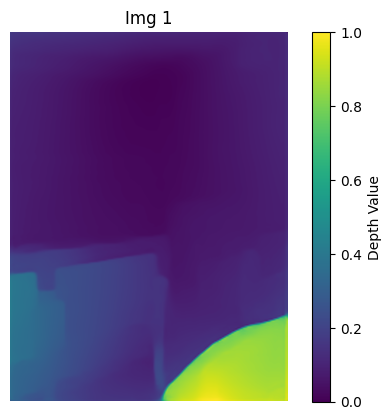

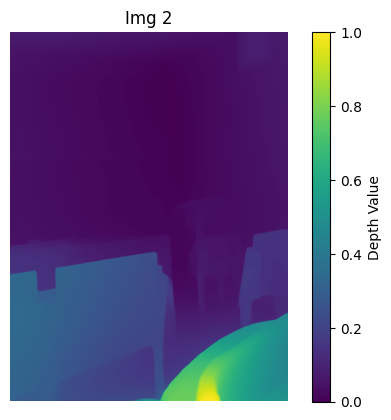

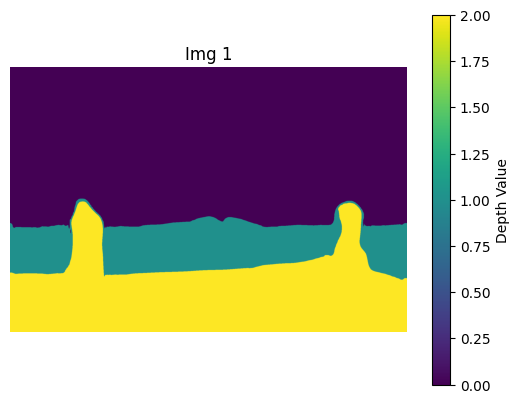

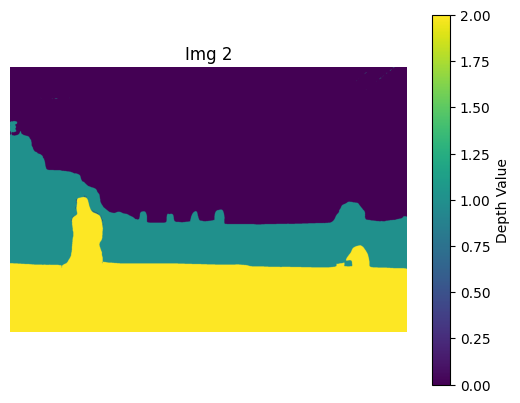

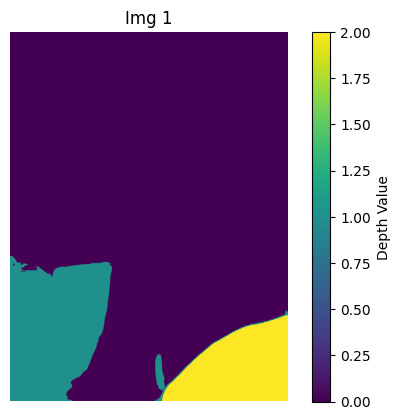

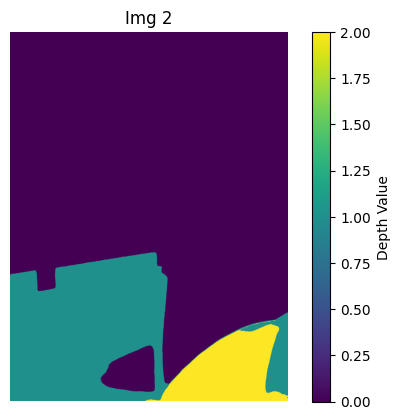

In [8]:
path = "imagens-t3/"
img1 = get_depth_from_images(midas_s, transform_s, device, path)  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
img2 = get_depth_from_images(midas_h, transform_h, device, path)  # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
if img1 is None or img2 is None:
    print("Nenhuma imagem foi carregada. Verifique o caminho fornecido.")
    exit()
for i in range(len(img1)):
    show_images(img1[i], img2[i])

for i in range(len(img1)):
    img1[i] = thresholds_depth(img1[i])
    img2[i] = thresholds_depth(img2[i])
    show_images(img1[i], img2[i])


### Percepção Visual com YOLO

In [5]:
def get_yolo_objects(model, img):
    """
    Executa a predição de um modelo YOLO em uma única imagem.

    Args:
        model: O modelo YOLO pré-carregado.
        img (np.ndarray): A imagem de entrada para detecção.

    Returns:
        list[Results]: Resultados da predição retornados pelo modelo.
    """
    output = model.predict(img, verbose=False)

    return output

def get_objects_from_images(model, path):
    """
    Processa múltiplas imagens de um caminho, executando a detecção YOLO em cada uma.

    Args:
        model: O modelo YOLO pré-carregado.
        img (np.ndarray): A imagem de entrada para detecção.
    
    Returns:
        list[Results]: Resultados da predição retornados pelo modelo.
    """

    output_list = []
    img_list = get_imgs(path)
    
    if not img_list:
        return None
    
    for img in img_list:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        output = get_yolo_objects(model, img)
        output_list.append(output)
    
    return output_list

In [12]:
MODOS_DE_PROFUNDIDADE_VALIDOS = {'median', 'mean'}


def get_object_depth_dict(img_objects, depth_frame, depth_mode: str = 'median', classes_alvo: list[str] | None = None):
    """
    Calcula a profundidade dos objetos detectados em uma imagem.

    Args:
        img_objects: Resultado do modelo de detecção YOLO.
        depth_frame (np.ndarray): Matriz de profundidade correspondente à imagem.
        depth_mode (str, optional): Método para estimar a profundidade do objeto. Padrão é 'median'.
        classes_alvo (list): Lista com nomes de objetos em inglês que serão considerados.

    Returns:
        list[dict]: Uma lista de dicionários ordenada em ordem decrescente de profundidade, onde cada dicionário contém:
                - 'nome' (str): O nome da classe do objeto.
                - 'profundidade' (float): O valor de profundidade calculado.
                - 'bbox' (list): As coordenadas [x1, y1, x2, y2] da caixa.
    """
    if classes_alvo is None:
       classes_alvo = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
                                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'bed', 'dining table', 'toilet',
                                'tv', 'microwave', 'oven', 'sink', 'refrigerator', 'vase', 'chair', 'board']

    if depth_mode not in MODOS_DE_PROFUNDIDADE_VALIDOS:
        raise ValueError(f"Modo de profundidade '{depth_mode}' inválido. "
                         f"Use um de: {MODOS_DE_PROFUNDIDADE_VALIDOS}")
    
    detected_objects = []

    nomes_classes = img_objects.names
    
    for obj in img_objects.boxes:
        classe_id = int(obj.cls[0])
        nome = nomes_classes[classe_id]

        if nome in classes_alvo:
            coord_box = obj.xyxy[0].int().cpu().numpy()
            x1, y1, x2, y2 = coord_box
            profundidades_box =  depth_frame[y1:y2, x1:x2]

            if depth_mode == 'median':
                obj_depth = float(np.median(profundidades_box))

            if depth_mode == 'mean':
                obj_depth = float(np.mean(profundidades_box))

            obj_data = {'nome': nome,
                        'profundidade': obj_depth,
                        'bbox': [x1, y1, x2, y2]}

            detected_objects.append(obj_data)
    
    detected_objects = sorted(detected_objects, key=lambda obj: obj['profundidade'], reverse=True)
    return detected_objects

#### Demonstração

In [15]:
import cv2
from ultralytics import YOLO

path = "imagens-t3/"

try:
    model = YOLO('yolov8n.pt')
except Exception as e:
    print(f"Erro ao carregar o modelo YOLO: {e}")

img_list = get_imgs(path)

for img in img_list:
    objetos = get_yolo_objects(model, img)

    input_batch = transform_s(img).to(device)
    profundidades = get_depth(midas_s, input_batch, img)
    objetos_detectados = get_object_depth_dict(objetos[0], profundidades,depth_mode='median')
    print(objetos_detectados)



[{'nome': 'person', 'profundidade': 0.751587986946106, 'bbox': [np.int32(248), np.int32(640), np.int32(476), np.int32(1282)]}, {'nome': 'bicycle', 'profundidade': 0.553165078163147, 'bbox': [np.int32(1617), np.int32(784), np.int32(1807), np.int32(1061)]}, {'nome': 'person', 'profundidade': 0.46279823780059814, 'bbox': [np.int32(1604), np.int32(630), np.int32(1799), np.int32(983)]}, {'nome': 'person', 'profundidade': 0.19814898073673248, 'bbox': [np.int32(912), np.int32(704), np.int32(975), np.int32(863)]}, {'nome': 'person', 'profundidade': 0.19571569561958313, 'bbox': [np.int32(1026), np.int32(698), np.int32(1069), np.int32(859)]}, {'nome': 'person', 'profundidade': 0.19134503602981567, 'bbox': [np.int32(1027), np.int32(695), np.int32(1088), np.int32(859)]}, {'nome': 'person', 'profundidade': 0.18390494585037231, 'bbox': [np.int32(132), np.int32(699), np.int32(214), np.int32(878)]}, {'nome': 'person', 'profundidade': 0.1670721471309662, 'bbox': [np.int32(781), np.int32(708), np.int32(